In [1]:
import numpy as np
import pandas as pd
import os
import csv

In [2]:
def read_data(data_file, types_file, miss_file, true_miss_file):
    # Read types of data from data file
    with open(types_file) as f:
        types_dict = [{k: v for k, v in row.items()}
                      for row in csv.DictReader(f, skipinitialspace=True)]

    # Read data from input file
    with open(data_file, 'r') as f:
        data = [[float(x) for x in rec] for rec in csv.reader(f, delimiter=',')]
        data = np.array(data)
    raw_data = data
    # Substitute NaN values by something (we assume we have the real missing value mask)
    if true_miss_file:
        with open(true_miss_file, 'r') as f:
            missing_positions = [[int(x) for x in rec] for rec in csv.reader(f, delimiter=',')]
            missing_positions = np.array(missing_positions)

        true_miss_mask = np.ones([np.shape(data)[0], len(types_dict)])
        true_miss_mask[missing_positions[:, 0] - 1, missing_positions[:, 1] - 1] = 0  # Indexes in the csv start at 1
        data_masked = np.ma.masked_where(np.isnan(data), data)
        # We need to fill the data depending on the given data...
        data_filler = []
        for i in range(len(types_dict)):
            if types_dict[i]['type'] == 'cat' or types_dict[i]['type'] == 'ordinal':
                aux = np.unique(data[:, i])
                data_filler.append(aux[0])  # Fill with the first element of the cat (0, 1, or whatever)
            else:
                data_filler.append(0.0)

        data = data_masked.filled(data_filler)
    else:
        true_miss_mask = np.ones([np.shape(data)[0], len(types_dict)])  # It doesn't affect our data

    # Construct the data matrices
    data_complete = []
    for i in range(np.shape(data)[1]):

        if types_dict[i]['type'] == 'cat':
            # Get categories
            cat_data = [int(x) for x in data[:, i]]
            categories, indexes = np.unique(cat_data, return_inverse=True)
            # Transform categories to a vector of 0:n_categories
            new_categories = np.arange(int(types_dict[i]['dim']))
            cat_data = new_categories[indexes]
            # Create one hot encoding for the categories
            aux = np.zeros([np.shape(data)[0], len(new_categories)])
            aux[np.arange(np.shape(data)[0]), cat_data] = 1
            data_complete.append(aux)

        elif types_dict[i]['type'] == 'ordinal':
            # Get categories
            cat_data = [int(x) for x in data[:, i]]
            categories, indexes = np.unique(cat_data, return_inverse=True)
            # Transform categories to a vector of 0:n_categories
            new_categories = np.arange(int(types_dict[i]['dim']))
            cat_data = new_categories[indexes]
            # Create thermometer encoding for the categories
            aux = np.zeros([np.shape(data)[0], 1 + len(new_categories)])
            aux[:, 0] = 1
            aux[np.arange(np.shape(data)[0]), 1 + cat_data] = -1
            aux = np.cumsum(aux, 1)
            data_complete.append(aux[:, :-1])

        elif types_dict[i]['type'] == 'count':
            if np.min(data[:, i]) == 0:
                aux = data[:, i] + 1
                data_complete.append(np.transpose([aux]))
            else:
                data_complete.append(np.transpose([data[:, i]]))



        else:
            data_complete.append(np.transpose([data[:, i]]))

    data = np.concatenate(data_complete, 1)

    # Read Missing mask from csv (contains positions of missing values)
    n_samples = np.shape(data)[0]
    n_variables = len(types_dict)
    miss_mask = np.ones([np.shape(data)[0], n_variables])
    # If there is no mask, assume all data is observed
    if os.path.isfile(miss_file):
        with open(miss_file, 'r') as f:
            missing_positions = [[int(x) for x in rec] for rec in csv.reader(f, delimiter=',')]
            missing_positions = np.array(missing_positions)
        miss_mask[missing_positions[:, 0] - 1, missing_positions[:, 1] - 1] = 0  # Indexes in the csv start at 1

    return data, types_dict, miss_mask, true_miss_mask, n_samples, raw_data

In [3]:
data, types_dict, miss_mask, true_miss_mask, n_samples, raw_data = read_data('data.csv', 'data_types.csv', 'Missing10-50_4.csv', None)

In [4]:
df = pd.DataFrame(data)

In [5]:
miss_mask.shape, data.shape

((30000, 24), (30000, 96))

In [6]:
raw_data.shape

(30000, 24)

In [7]:
miss_mask[:, -1].sum()

15000.0

In [8]:
types_dict

[{'type': 'pos', 'dim': '1', 'nclass': ''},
 {'type': 'cat', 'dim': '3', 'nclass': '3'},
 {'type': 'cat', 'dim': '7', 'nclass': '7'},
 {'type': 'cat', 'dim': '4', 'nclass': '4'},
 {'type': 'count', 'dim': '1', 'nclass': ''},
 {'type': 'ordinal', 'dim': '11', 'nclass': '11'},
 {'type': 'ordinal', 'dim': '11', 'nclass': '11'},
 {'type': 'ordinal', 'dim': '11', 'nclass': '11'},
 {'type': 'ordinal', 'dim': '11', 'nclass': '11'},
 {'type': 'ordinal', 'dim': '11', 'nclass': '11'},
 {'type': 'ordinal', 'dim': '11', 'nclass': '11'},
 {'type': 'real', 'dim': '1', 'nclass': ''},
 {'type': 'real', 'dim': '1', 'nclass': ''},
 {'type': 'real', 'dim': '1', 'nclass': ''},
 {'type': 'real', 'dim': '1', 'nclass': ''},
 {'type': 'real', 'dim': '1', 'nclass': ''},
 {'type': 'real', 'dim': '1', 'nclass': ''},
 {'type': 'pos', 'dim': '1', 'nclass': ''},
 {'type': 'pos', 'dim': '1', 'nclass': ''},
 {'type': 'pos', 'dim': '1', 'nclass': ''},
 {'type': 'pos', 'dim': '1', 'nclass': ''},
 {'type': 'pos', 'dim':

In [17]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,20000.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,0.0,1.0
1,120000.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0.0,1.0
2,90000.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,1.0,0.0
3,50000.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1.0,0.0
4,50000.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1.0,0.0


In [10]:
path = '../Results/model_HIVAE_inputDropout_Wine_Missing10-50_1_z2_y5_s10_batch100/model_HIVAE_inputDropout_Wine_Missing10-50_1_z2_y5_s10_batch100_data'

dt = np.array(pd.read_csv(path + '_true.csv', header=None))
dr = np.array(pd.read_csv(path + '_reconstruction.csv', header=None))

In [12]:
dft = pd.DataFrame(dt)

In [18]:
dft.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0,1.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0,1.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0,1.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0,1.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0,1.0


In [19]:
dfr = pd.DataFrame(dr)

In [20]:
dfr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,7.36,0.27,0.36,20.7,0.045,45.000,170.0,1.0010,3.000,0.45,8.8,6.0,1.0
1,6.30,0.30,0.34,1.6,0.043,14.000,132.0,0.9930,3.300,0.49,9.5,6.0,1.0
2,8.10,0.28,0.40,6.9,0.050,30.000,97.0,0.9970,3.260,0.44,10.1,6.0,1.0
3,7.20,0.23,0.32,8.5,0.058,47.000,186.0,0.9956,3.190,0.40,9.9,6.0,1.0
4,7.20,0.23,0.32,8.5,0.058,32.426,186.0,0.9956,3.155,0.40,9.9,6.0,1.0


In [77]:
dt_norm = dt / np.linalg.norm(dt)
dr_norm = dr / np.linalg.norm(dr)
req_loss = dt_norm - dr_norm

In [78]:
np.linalg.norm(req_loss)

0.10093097579787809

In [25]:
np.sum(np.abs(dt[:,-1] - dr[:,-1]))/dt.shape[0]

0.015699553640141604

In [81]:
path = '../Results_csv/model_HIVAE_inputDropout_Wine_Missing10-50_1_z2_y5_s10_batch100/model_HIVAE_inputDropout_Wine_Missing10-50_1_z2_y5_s10_batch100'

tre = np.array(pd.read_csv(path + '_train_error.csv', header=None))
tee = np.array(pd.read_csv(path + '_test_error.csv', header=None))

In [95]:
path = '../Results_test_csv/model_HIVAE_inputDropout_Wine_Missing10-50_1_z2_y5_s10_batch100/model_HIVAE_inputDropout_Wine_Missing10-50_1_z2_y5_s10_batch100'

test_tre = np.array(pd.read_csv(path + '_train_error.csv', header=None))
test_tee = np.array(pd.read_csv(path + '_test_error.csv', header=None))

In [85]:
import matplotlib.pyplot as plt

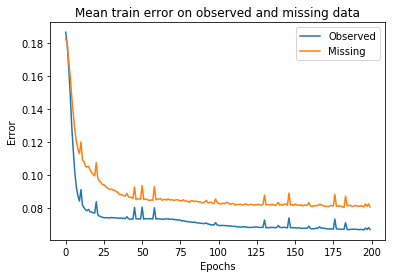

In [110]:
plt.plot(tre.mean(1), label='Observed')
plt.plot(tee.mean(1), label='Missing')
plt.title('Mean train error on observed and missing data')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Epochs');

In [113]:
print('At final epoch:')
print('   Mean train error on observed data:', tre[-1,:].mean())
print('   Mean train error on missing data:', tee[-1,:].mean())

At final epoch:
   Mean train error on observed data: 0.06685086269063642
   Mean train error on missing data: 0.08056757746020328


In [112]:
print('Mean test error on observed data:', test_tre.mean())
print('Mean test error on missing data:', test_tee.mean())

Mean test error on observed data: 0.0669244365487943
Mean test error on missing data: 0.07974516545425575


In [124]:
A = np.random.randint(2, size=(4000, 4100))